In [42]:
import csv
import numpy as np
import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import *
from sklearn import metrics
from math import sqrt
from numpy import nan
import math
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns
%matplotlib inline
from prettytable import PrettyTable
import warnings; warnings.simplefilter('ignore')
from sklearn.metrics import roc_curve, roc_auc_score

In [43]:
path = os.getcwd()
path

'C:\\Users\\venu\\Desktop\\Stock Market Analysis'

# Pre-processing the Data

In [1]:
def pre_process_data(data,null_threshold):
    data.drop(columns=['Unixtime','Date'],axis=1,inplace=True)
    total = data.shape[0]
    for col in data.columns:
        if null_threshold * total / 100 <= data[col].isnull().sum():
            data.drop(columns=[col],axis=1,inplace=True)
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(axis=0,inplace=True)
    return data

# Removing columns based on the dependent column

In [45]:
def dependent_column(data,column):
    cols = [col for col in data.columns if "next" not in col.lower()]
    cols.append(column)
    data = data[cols]
    return (data,column)

# ---

In [46]:
def create_target_col(name,dataframe,range_val):
    target = []
    for i in range(0,dataframe.shape[0]):
        if(dataframe.iloc[i].loc['Close Price GR'] >= range_val):
            target.append(1)
        else:
            target.append(0)
    dataframe['Target'] = target
    
    X = dataframe.drop('Target', axis=1)
    Y = dataframe['Target']
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
    
    penalty = ['l1', 'l2']
    C = [0.001,0.01,0.1,1,10,100]
    
    best = parameters_tuning(penalty,C,X_train, y_train)
#     print("---------------------------------------------------------------------")
#     print("Best Penalty:", best[0]) 
#     print("Best C - value:", best[1])

    logmodel = LogisticRegression(penalty = best[0], C = best[1],random_state = 0)
    logmodel.fit(X_train, y_train)
    
    y_pred = logmodel.predict(X_test)
    
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred)

    print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, y_pred))

    plt.figure()
    lw = 2
    
    plt.plot(false_positive_rate, true_positive_rate,color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred))
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('Receiver Operating Characteristic - Logistic regression')
    plt.legend(loc="lower right")
    plt.show()
    
    confidence = logmodel.score(X_test, y_test)
    confidence = round(confidence,3)
    
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    rmse= round(rmse,3)
    
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mae = round(mae,3)
    
    mse = metrics.mean_squared_error(y_test, y_pred)
    mse= round(mse,3)
    
    ols_values = OLS_Regression(X_train,y_train)
    
    logistic.add_row([name,range_val,confidence, ols_values[0],rmse,mae,mse])
    
    confusion(name,range_val,y_test,y_pred)

In [47]:
def parameters_tuning(penalty,C,X_train, y_train):
    values=[]
    
    logistic = LogisticRegression()
    
    hyperparameters = dict(C=C, penalty=penalty)
    
    clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)
    
    best_model = clf.fit(X_train, y_train)
    
    penalty_val = best_model.best_estimator_.get_params()['penalty']
    c_val  = best_model.best_estimator_.get_params()['C']
    
    values.append(penalty_val)
    values.append(c_val)
    
    return values

# OLS Regression

In [48]:
def OLS_Regression(X_train,Y_train):
    values = []
    ols_model = sm.OLS(Y_train, X_train).fit()
    
    adj_r =round(ols_model.rsquared_adj,3)
    aic = round(ols_model.aic,3)
    bic = round(ols_model.bic,3)
    f = round(ols_model.fvalue,3)
    
    values.extend([adj_r,aic,bic,f])
    return values

In [49]:
def confusion(name,range_val,y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)

    accuracy = float(cm.diagonal().sum())/len(y_test)
    acc = round(accuracy,2)
    
    TP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[1][1]
    
    p0 = TP / (FN + TP)
    if (math.isnan(p0)):
        p0 = 0.00
    else:
        p0 = round(p0,2)
     
    p1 = TN / (FP + TN)
    
    if (math.isnan(p1)):
        p1 = 0.00
    else:
        p1 = round(p1,2)
    
    r0 = TP / (TP + FP)
    if (math.isnan(r0)):
        r0 = 0.00
    else:
        r0 = round(r0,2)
    
    r1 = TN / (FN + TN)
    if (math.isnan(r1)):
        r1 = 0.00
    else:
        r1 = round(r1,2)
    
    logistic_table_tuning.add_row([name,range_val,acc,p0,p1,r0,r1])

# Pretty Table

In [74]:
logistic = PrettyTable()
logistic.field_names = ["Company_name","Range","R-Squared","Adj_R-Squared","RMSE","MAE","MSE"]

In [75]:
logistic_table_tuning = PrettyTable()
logistic_table_tuning.field_names = ["Company_name","Range","Accuracy","Precision(0)","Precision(1)","Recall(0)","Recall(1)"]

In [76]:
logistic_table_tuning.clear_rows()

In [77]:
logistic.clear_rows()

mod500112GR.csv
roc_auc_score for Logistic Regression:  0.5146466054859808


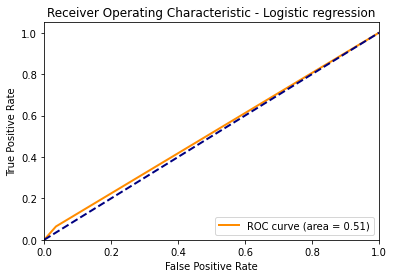

roc_auc_score for Logistic Regression:  0.5092504138438988


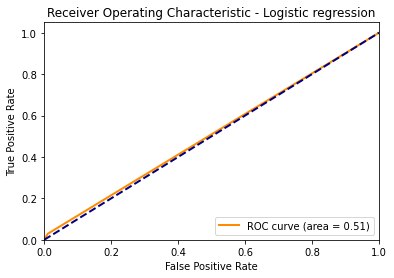

roc_auc_score for Logistic Regression:  0.5192030192030193


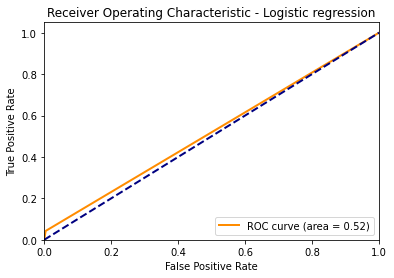

roc_auc_score for Logistic Regression:  0.5227672587131368


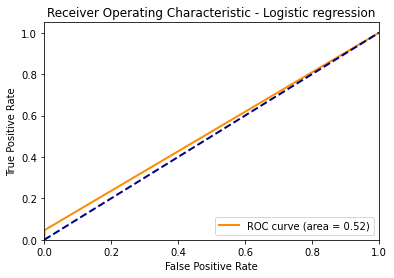

roc_auc_score for Logistic Regression:  0.5375


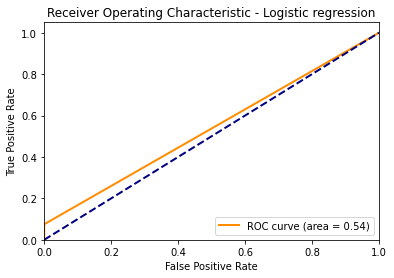

roc_auc_score for Logistic Regression:  0.5227272727272727


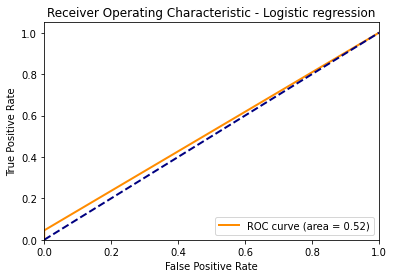

roc_auc_score for Logistic Regression:  0.5357142857142857


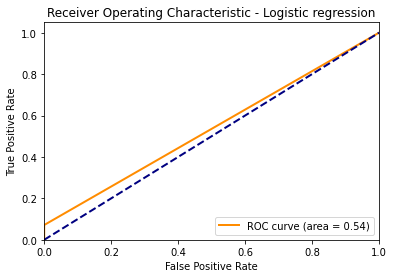

roc_auc_score for Logistic Regression:  0.5625


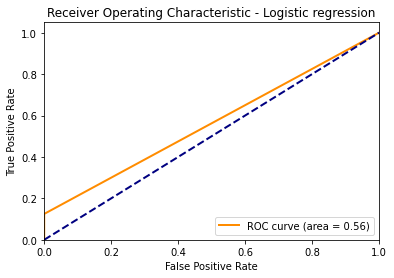

roc_auc_score for Logistic Regression:  0.5


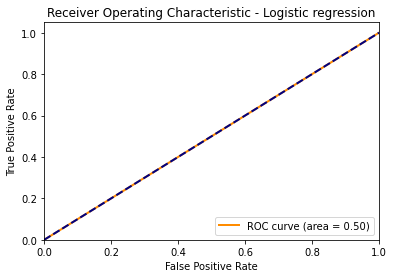

roc_auc_score for Logistic Regression:  0.4993796526054591


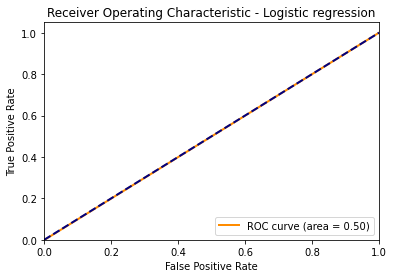

roc_auc_score for Logistic Regression:  0.5


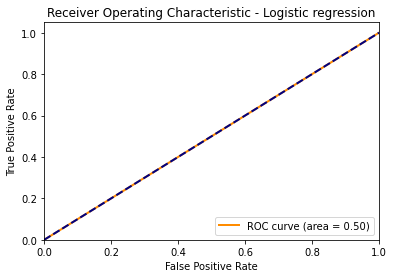

Wall time: 34.4 s


In [78]:
%%time
for filename in os.listdir(os.path.join(path,"Data/Stock")):
    if filename.startswith("mod") and filename.endswith("GR.csv"):
        print(filename)
        name = filename.split(".")[0]
        df = pd.read_csv(os.path.join(path,"Data\Stock\\" + filename))
        df = pre_process_data(df,60)
#         print(type(df))
        df, y = dependent_column(df, "Next Day Close Price GR")
#         print(df)
        range_list = [0.005,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
        for i in range(0,len(range_list)):
            create_target_col(name,df,range_list[i])
        break

In [79]:
print(logistic)

+--------------+-------+-----------+---------------+-------+-------+-------+
| Company_name | Range | R-Squared | Adj_R-Squared |  RMSE |  MAE  |  MSE  |
+--------------+-------+-----------+---------------+-------+-------+-------+
| mod500112GR  | 0.005 |   0.602   |      0.57     | 0.631 | 0.398 | 0.398 |
| mod500112GR  |  0.01 |   0.704   |     0.572     | 0.544 | 0.296 | 0.296 |
| mod500112GR  |  0.02 |   0.858   |      0.56     | 0.377 | 0.142 | 0.142 |
| mod500112GR  |  0.03 |   0.923   |     0.489     | 0.277 | 0.077 | 0.077 |
| mod500112GR  |  0.04 |   0.954   |     0.416     | 0.214 | 0.046 | 0.046 |
| mod500112GR  |  0.05 |   0.974   |     0.367     | 0.161 | 0.026 | 0.026 |
| mod500112GR  |  0.06 |   0.984   |     0.308     | 0.127 | 0.016 | 0.016 |
| mod500112GR  |  0.07 |   0.991   |     0.249     | 0.093 | 0.009 | 0.009 |
| mod500112GR  |  0.08 |   0.994   |     0.267     | 0.079 | 0.006 | 0.006 |
| mod500112GR  |  0.09 |   0.994   |     0.339     | 0.079 | 0.006 | 0.006 |

In [80]:
print(logistic_table_tuning)

+--------------+-------+----------+--------------+--------------+-----------+-----------+
| Company_name | Range | Accuracy | Precision(0) | Precision(1) | Recall(0) | Recall(1) |
+--------------+-------+----------+--------------+--------------+-----------+-----------+
| mod500112GR  | 0.005 |   0.6    |     0.6      |     0.55     |    0.96   |    0.06   |
| mod500112GR  |  0.01 |   0.7    |     0.71     |     0.54     |    0.99   |    0.03   |
| mod500112GR  |  0.02 |   0.86   |     0.86     |     0.62     |    1.0    |    0.04   |
| mod500112GR  |  0.03 |   0.92   |     0.92     |     0.75     |    1.0    |    0.05   |
| mod500112GR  |  0.04 |   0.95   |     0.95     |     1.0      |    1.0    |    0.08   |
| mod500112GR  |  0.05 |   0.97   |     0.97     |     1.0      |    1.0    |    0.05   |
| mod500112GR  |  0.06 |   0.98   |     0.98     |     1.0      |    1.0    |    0.07   |
| mod500112GR  |  0.07 |   0.99   |     0.99     |     1.0      |    1.0    |    0.12   |
| mod50011